# Installation, importering och skapa motor.

In [1]:
#!pip install sqlalchemy
#!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

In [3]:
def new_engine(dialect, server, database, user = None, password = None, integrated_security = True):
    if integrated_security:
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
engine = new_engine('mssql','Ian', 'AdventureWorks2022')

mssql://Ian/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
connection = engine.connect()

In [6]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


# SQL Query

## Anställda 

In [7]:
# Antal anställda per land

df = pd.read_sql(sql = """SELECT F.Name AS Country
, COUNT(F.Name) AS Employees
FROM HumanResources.Employee AS A INNER JOIN Person.Person AS B 
	ON A.BusinessEntityID = B.BusinessEntityID 
	INNER JOIN Person.BusinessEntityAddress AS C 
		ON B.BusinessEntityID = C.BusinessEntityID 
		INNER JOIN Person.Address AS D 
			ON C.AddressID = D.AddressID 
			INNER JOIN Person.StateProvince AS E 
				ON D.StateProvinceID = E.StateProvinceID 
				INNER JOIN Person.CountryRegion AS F ON E.CountryRegionCode = F.CountryRegionCode
GROUP BY F.Name;""", con = connection)

df.head(6)

,Country,Employees
0,Australia,1
1,Canada,2
2,France,1
3,Germany,1
4,United Kingdom,1
5,United States,284


## Säljare 2013

In [8]:
# Hur mycket varje säljare sålt för under 2013

df = pd.read_sql(sql ="""SELECT TOP 20 FirstName
	, LastName
	, BusinessEntityID
	, CONCAT(FORMAT(SUM(SalesQuota)/1000000.0, 'N2'), 'M') AS TotalSales2013
FROM (
	SELECT A.BusinessEntityID
	, A.SalesQuota
	, B.FirstName
	, B.LastName
	FROM Sales.SalesPersonQuotaHistory AS A INNER JOIN Person.Person AS B
		ON A.BusinessEntityID = B.BusinessEntityID
	WHERE QuotaDate BETWEEN '2013-01-01' AND '2013-12-31'
) AS QuotaSubquery
GROUP BY BusinessEntityID, FirstName, LastName
ORDER BY SUM(SalesQuota) DESC;""", con = connection)

df.head(16)

,FirstName,LastName,BusinessEntityID,TotalSales2013
0,Jae,Pak,289,5.09M
1,Michael,Blythe,275,4.84M
2,Linda,Mitchell,276,4.72M
3,Jillian,Carson,277,4.23M
4,Ranjit,Varkey Chudukatil,290,3.43M
5,Shu,Ito,281,2.79M
6,Tsvi,Reiter,279,2.74M
7,José,Saraiva,282,2.57M
8,Rachel,Valdez,288,1.66M
9,Garrett,Vargas,278,1.66M


## Löner

In [9]:
# Bevis att de med samma titel har samma lön, oberoende av anställningstid

df = pd.read_sql(sql = """SELECT TOP 10 A.BusinessEntityID
	, A.JobTitle
	, A.HireDate
	, B.Rate

FROM HumanResources.Employee AS A INNER JOIN HumanResources.EmployeePayHistory AS B
	ON A.BusinessEntityID = B.BusinessEntityID

WHERE JobTitle = 'Production Technician - WC60'

ORDER BY A.HireDate;""", con = connection)

df.head(10)

,BusinessEntityID,JobTitle,HireDate,Rate
0,28,Production Technician - WC60,2006-06-30,12.45
1,44,Production Technician - WC60,2008-12-08,12.45
2,70,Production Technician - WC60,2008-12-15,12.45
3,33,Production Technician - WC60,2008-12-17,12.45
4,42,Production Technician - WC60,2008-12-27,12.45
5,32,Production Technician - WC60,2008-12-29,12.45
6,43,Production Technician - WC60,2009-01-02,12.45
7,31,Production Technician - WC60,2009-01-04,12.45
8,41,Production Technician - WC60,2009-01-21,12.45
9,29,Production Technician - WC60,2009-01-23,12.45


## Defekthantering

In [10]:
# Produkter med högst procentuell defekthantering

df = pd.read_sql(sql = """SELECT TOP 10 B.Name
	, A.ProductID
	, SUM(A.OrderQty) TotalOrder
	, SUM(A.ScrappedQty) TotalScrapped
	, FORMAT(SUM(A.ScrappedQty) * 100.0 /SUM(OrderQty), 'N2') AS Percentage
	
FROM Production.WorkOrder AS A INNER JOIN Production.Product AS B
	ON A.ProductID = B.ProductID
GROUP BY A.ProductID, B.Name 
ORDER BY Percentage DESC;""", con = connection)

df.head(10)

,Name,ProductID,TotalOrder,TotalScrapped,Percentage
0,"ML Road Frame - Red, 52",733,800,6,0.75
1,"Mountain-100 Black, 42",776,634,4,0.63
2,"HL Touring Frame - Blue, 60",893,2311,14,0.61
3,Fork Crown,350,118001,692,0.59
4,Touring Rear Wheel,829,14751,87,0.59
5,Fork End,331,236002,1374,0.58
6,"Road-450 Red, 44",756,346,2,0.58
7,"Road-650 Red, 60",760,2232,13,0.58
8,ML Mountain Front Wheel,816,17809,100,0.56
9,"Road-650 Black, 52",770,2270,12,0.53


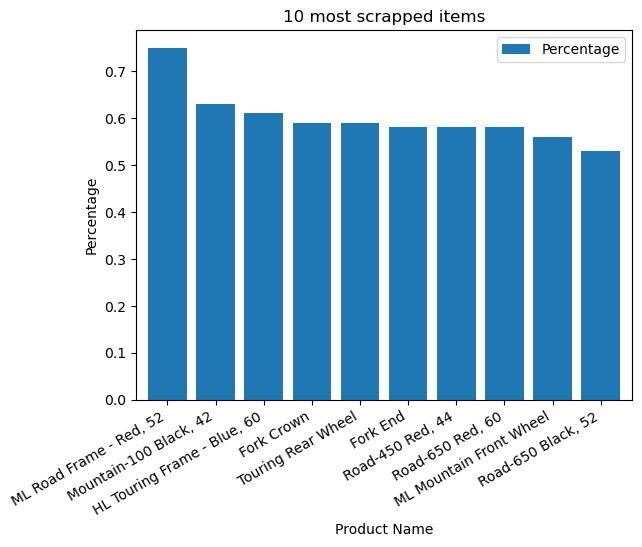

In [11]:
# Bar plot for att visa de tio produkter mest flest defekter

df['Percentage'] = df['Percentage'].astype(float)
ax = df.plot(x = 'Name', y = 'Percentage',  kind = 'bar', title = '10 most scrapped items', width = 0.8, align = 'center')

plt.xlabel('Product Name')

plt.ylabel('Percentage')

plt.xticks(rotation = 30, horizontalalignment = 'right')
plt.show()

## Jae Pak

In [12]:
# Jae Paks tio mest sålda produkter

df = pd.read_sql(sql = """SELECT TOP 10 Name AS Product
	, ProductID
	, SUM(OrderQty) AS SoldItem
FROM (SELECT B.FirstName
	, B.LastName
	, A.SalesOrderID
	, A.SalesPersonID
	, C.ProductID
	, D.Name
	, C.OrderQty
	, A.TotalDue
FROM Sales.SalesOrderHeader AS A INNER JOIN Person.Person AS B
	ON A.SalesPersonID = B.BusinessEntityID
	INNER JOIN Sales.SalesOrderDetail AS C
		ON A.SalesOrderID = C.SalesOrderID
		INNER JOIN Production.Product AS D
			ON C.ProductID = D.ProductID
WHERE SalesPersonID = 289) AS Sub
GROUP BY ProductID, Name
ORDER BY SoldItem DESC;""", con = connection)

df.head(10)

,Product,ProductID,SoldItem
0,AWC Logo Cap,712,744
1,"Long-Sleeve Logo Jersey, L",715,739
2,"Full-Finger Gloves, L",863,558
3,"Sport-100 Helmet, Blue",711,536
4,"Sport-100 Helmet, Black",708,518
5,"Women's Mountain Shorts, L",869,498
6,"Sport-100 Helmet, Red",707,498
7,"Women's Mountain Shorts, S",867,470
8,"Classic Vest, S",864,469
9,"Short-Sleeve Classic Jersey, XL",884,434


# Konfidensintervall

In [13]:
# Ta fram konfidensintervallet för ProduktID 809 (ML Mountain Handlebars) under året 2012

df = pd.read_sql(sql = """SELECT ProductID
	, SUM(OrderQty) - SUM(ScrappedQty) AS Quantity
FROM Production.WorkOrder
GROUP BY ProductID,
	EndDate
HAVING EndDate BETWEEN '2012-01-01' AND '2012-12-31' AND ProductID = 809;""" , con = connection)


df['Quantity'] = df['Quantity'].astype(float)
mean = np.mean(df['Quantity'])
std = np.std(df['Quantity'], ddof=1)
n = np.size(df['Quantity'])
ci_perc = 0.95

quantile = t.ppf(1 - (1 - ci_perc) / 2, n-1)

ci_lower = mean - quantile*(std/np.sqrt(n))
ci_upper = mean + quantile*(std/np.sqrt(n))

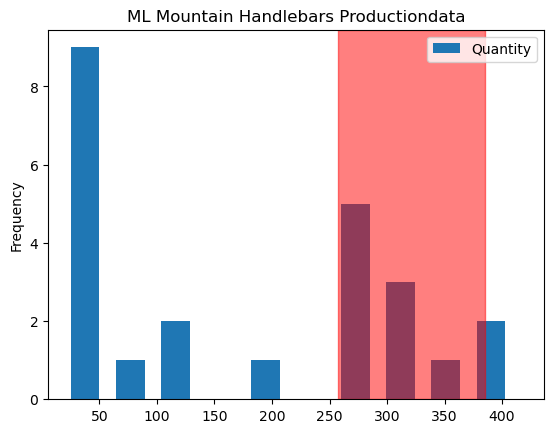

In [21]:
# Ta fram all produktionsdata för produktID 809 (ML Mountain Handlebars)

df = pd.read_sql(sql = """SELECT ProductID
	, SUM(OrderQty) - SUM(ScrappedQty) AS Quantity
	, EndDate
FROM Production.WorkOrder
GROUP BY ProductID
	, EndDate
HAVING  ProductID = 809;""" , con = connection)

# Plotta datan med ett histogram, markera konfidensintervallet

ax = df.plot(x = 'ProductID', y = 'Quantity',  kind = 'hist', width = 25, title = 'ML Mountain Handlebars Productiondata',  align = 'mid')

plt.axvspan(ci_lower, ci_upper, color='red', alpha=0.5)


In [15]:
# Antal producerade ML Mountain Handlebars

df = pd.read_sql(sql = """SELECT ProductID
	, SUM(OrderQty) - SUM(ScrappedQty) AS Quantity
	, EndDate
FROM Production.WorkOrder
GROUP BY ProductID
	, EndDate
HAVING  ProductID = 809;""", con = connection)

df.head(24)

,ProductID,Quantity,EndDate
0,809,313,2012-06-18
1,809,417,2012-07-19
2,809,387,2012-08-19
3,809,274,2012-09-18
4,809,348,2012-10-19
5,809,296,2012-11-18
6,809,214,2012-12-19
7,809,309,2013-01-19
8,809,265,2013-02-16
9,809,284,2013-03-19


In [16]:
# Kod för att ta fram produkters bl.a högsta, minsta och medelvärde för en dags produktion

df = pd.read_sql(sql = """SELECT B.Name 
	, A.ProductID
	, SUM(A.OrderQty) AS Total
	, MAX(A.OrderQty) AS Highest
	, AVG(A.OrderQty) AS Average
	, MIN(A.OrderQty) AS Minimum
	, MAX(A.OrderQty) - MIN(A.OrderQty) AS Diff
FROM Production.WorkOrder AS A INNER JOIN Production.Product AS B
	ON A.ProductID = B.ProductID

GROUP BY A.ProductID
	, B.Name

HAVING MIN(OrderQty) <> 1

ORDER BY Diff DESC;""", con = connection)

df.head(29)

,Name,ProductID,Total,Highest,Average,Minimum,Diff
0,BB Ball Bearing,3,911890,39570,834,10,39560
1,Seat Stays,532,469468,24124,429,4,24120
2,Blade,316,236002,12062,215,2,12060
3,Chain Stays,324,234734,12062,214,2,12060
4,Fork End,331,236002,12062,215,2,12060
5,HL Hub,401,128226,5928,117,2,5926
6,Road End Caps,329,96080,4868,88,2,4866
7,Touring End Caps,330,30054,3334,82,2,3332
8,LL Hub,400,57583,3046,69,2,3044
9,Mountain End Caps,328,62302,2754,67,2,2752
